# MULTI AGENT REINFORCEMENT LEARNING - ASSIGNMENT 3

## DEFINING THE MAZE


Agents' positions (row, column): [(5, 9), (6, 8), (4, 3), (3, 7)]
Destinations' positions (row, column): [(1, 5), (5, 8), (5, 1), (8, 4)]


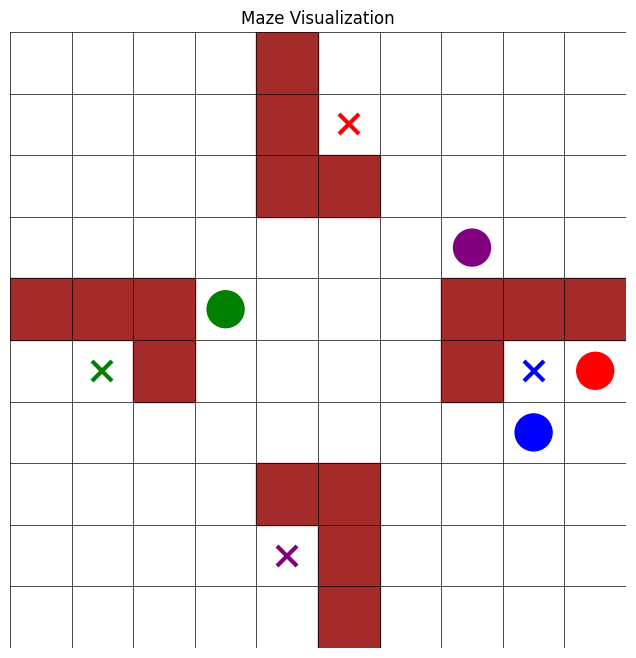

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import random
import numpy as np

# Initialize the maze dimensions and empty grid
maze_size = 10
maze = np.zeros((maze_size, maze_size), dtype=int)

# Define custom walls (1 indicates a wall)
# Example: Add some walls manually
walls = [
    (0, 4), (1, 4), (2, 4),(2,5),
    (4, 7), (4, 8), (4, 9),(5,7),
    (4, 0), (4, 1), (4, 2),(5,2),
    (7, 5), (8, 5), (9, 5),(7,4)
]
for wall in walls:
    maze[wall] = 1

# Randomly initialize agents (2 indicates an agent)
num_agents = 4
agents = []
while len(agents) < num_agents:
    x, y = random.randint(0, maze_size-1), random.randint(0, maze_size-1)
    if maze[x, y] == 0:  # Ensure the position is free
        agents.append((x, y))
        maze[x, y] = 2

# Define custom destinations (3 indicates a destination)
destinations = [(1, 5), (5, 8), (5, 1), (8, 4)]
for dest in destinations:
    if maze[dest] == 0:  # Ensure the position is free
        maze[dest] = 3



# Print agent and destination positions
print("\nAgents' positions (row, column):", agents)
print("Destinations' positions (row, column):", destinations)

# Define colors for agents
agent_colors = ['red', 'blue', 'green', 'purple']

# Function to plot the maze
def plot_maze(maze, agents, destinations):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, maze_size)
    ax.set_ylim(0, maze_size)

    # Draw the grid
    for x in range(maze_size):
        for y in range(maze_size):
            if maze[x, y] == 1:  # Walls
                ax.add_patch(patches.Rectangle((y, maze_size-x-1), 1, 1, color='brown'))
            elif maze[x, y] == 2:  # Agents
                agent_index = agents.index((x, y))
                ax.add_patch(patches.Circle((y+0.5, maze_size-x-1+0.5), 0.3, color=agent_colors[agent_index]))
            elif maze[x, y] == 3:  # Destinations
                agent_index = destinations.index((x, y))
                color = agent_colors[agent_index]
                ax.plot(y+0.5, maze_size-x-1+0.5, marker='x', color=color, markersize=15, markeredgewidth=3)

    # Draw grid lines
    for i in range(maze_size+1):
        ax.plot([0, maze_size], [i, i], color='black', linewidth=0.5)
        ax.plot([i, i], [0, maze_size], color='black', linewidth=0.5)

    ax.set_aspect('equal')
    ax.axis('off')  # Turn off axes for a cleaner look
    plt.title("Maze Visualization")
    plt.show()

# Call the plotting function
plot_maze(maze, agents, destinations)


# Q - learning BASED SOLUTION

In [40]:
import numpy as np
from collections import defaultdict

# Actions: [Stay, Up, Down, Left, Right]
ACTIONS = [(0, 0), (-1, 0), (1, 0), (0, -1), (0, 1)]
ACTION_NAMES = ['Stay', 'Up', 'Down', 'Left', 'Right']
NUM_ACTIONS = len(ACTIONS)
GAMMA = 0.9  # Discount factor
ALPHA = 0.1  # Learning rate
EPSILON = 0.2
MAX_EPISODES = 500

# Maze environment
class MultiAgentMazeMinMax:
    def __init__(self, maze, agents, destinations):
        self.maze = maze
        self.agents = agents
        self.destinations = destinations
        self.num_agents = len(agents)
        self.state = tuple(agents)
        self.steps_taken = [0] * self.num_agents  # Track steps per agent

    def is_valid_position(self, pos):
        x, y = pos
        return 0 <= x < maze_size and 0 <= y < maze_size and self.maze[x, y] != 1

    def reset(self):
        self.state = tuple(agents)
        self.steps_taken = [0] * self.num_agents
        return self.state

    def step(self, actions):
        next_state = list(self.state)
        rewards = []
        for i, action in enumerate(actions):
            current_pos = self.state[i]
            move = ACTIONS[action]
            new_pos = (current_pos[0] + move[0], current_pos[1] + move[1])

            # Check if new position is valid
            if self.is_valid_position(new_pos) and new_pos not in next_state:
                next_state[i] = new_pos

            # Increment step count
            self.steps_taken[i] += 1

            # Calculate reward
            if new_pos == self.destinations[i]:
                reward = 10  # Reached goal
            else:
                reward = -1  # Step penalty
            rewards.append(reward)

        self.state = tuple(next_state)
        done = all(next_state[i] == self.destinations[i] for i in range(self.num_agents))
        return self.state, rewards, done, max(self.steps_taken)

# Q-learning with max-time minimization
def train_agents_minmax(maze_env):
    q_tables = [defaultdict(lambda: np.zeros(NUM_ACTIONS)) for _ in range(maze_env.num_agents)]
    min_max_time = float('inf')  # Track the minimum maximum time

    for episode in range(MAX_EPISODES):
        state = maze_env.reset()
        done = False

        while not done:
            actions = []
            for i in range(maze_env.num_agents):
                if np.random.rand() < EPSILON:
                    action = np.random.choice(NUM_ACTIONS)  # Explore
                else:
                    action = np.argmax(q_tables[i][state[i]])  # Exploit
                actions.append(action)

            next_state, rewards, done, max_time = maze_env.step(actions)

            # Update Q-values
            for i in range(maze_env.num_agents):
                current_q = q_tables[i][state[i]][actions[i]]
                next_max_q = np.max(q_tables[i][next_state[i]])
                q_tables[i][state[i]][actions[i]] = current_q + ALPHA * (
                    rewards[i] + GAMMA * next_max_q - current_q
                )

            state = next_state

        # Update minimum max time
        min_max_time = min(min_max_time, max_time)

    return q_tables, min_max_time

# Train and evaluate
maze_env = MultiAgentMazeMinMax(maze, agents, destinations)
q_tables, min_max_time = train_agents_minmax(maze_env)

print(f"\nMinimum maximum time achieved: {min_max_time}")




Minimum maximum time achieved: 10


## PRINTING THE OPTIMAL PATH

In [41]:
def print_optimal_paths(maze_env, q_tables):
    """
    Print the optimal path taken by each agent based on their respective Q-table.
    """
    for i in range(maze_env.num_agents):
        print(f"\nAgent {i+1} (Color: {agent_colors[i]}):")
        current_pos = maze_env.agents[i]
        destination = maze_env.destinations[i]
        path = [current_pos]

        while current_pos != destination:
            # Get the best action from the Q-table
            best_action_index = np.argmax(q_tables[i][current_pos])
            move = ACTIONS[best_action_index]
            next_pos = (current_pos[0] + move[0], current_pos[1] + move[1])

            # Check if the move is valid
            if maze_env.is_valid_position(next_pos):
                current_pos = next_pos
                path.append(current_pos)
            else:
                print(f"Invalid move encountered at {current_pos}. Exiting.")
                break

        print(f"Optimal Path: {path}")

print_optimal_paths(maze_env,q_tables)



Agent 1 (Color: red):
Optimal Path: [(5, 9), (6, 9), (6, 8), (6, 7), (6, 6), (5, 6), (4, 6), (3, 6), (2, 6), (1, 6), (1, 5)]

Agent 2 (Color: blue):
Optimal Path: [(6, 8), (5, 8)]

Agent 3 (Color: green):
Optimal Path: [(4, 3), (5, 3), (6, 3), (6, 2), (6, 1), (5, 1)]

Agent 4 (Color: purple):
Optimal Path: [(3, 7), (3, 6), (4, 6), (4, 5), (4, 4), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (8, 4)]


## VISUALIZING THE OPTIMAL PATH ON THE MAZE

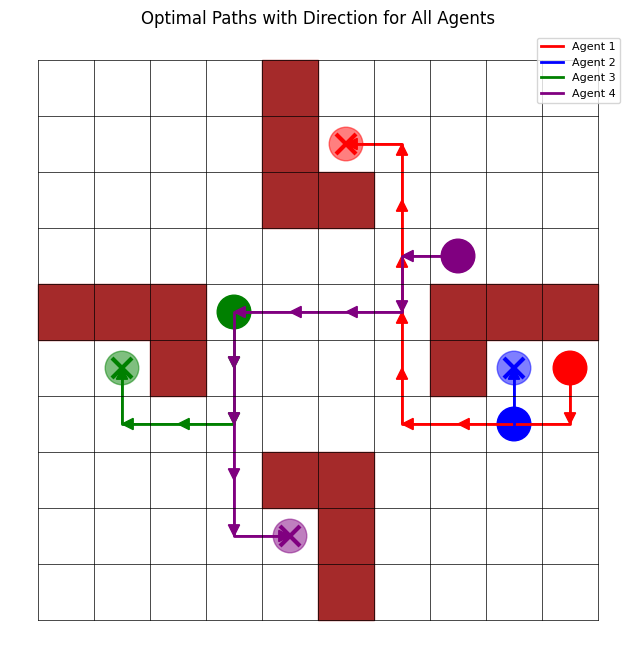

In [42]:
def visualize_optimal_paths_with_arrows(maze, maze_env, q_tables):
    """
    Visualize the maze with optimal paths for all agents, including arrows for direction.
    """
    # Create a copy of the maze for visualization
    path_grid = np.copy(maze)
    agent_colors = ['red', 'blue', 'green', 'purple']
    fig, ax = plt.subplots(figsize=(8, 8))

    # Draw the maze grid
    for x in range(maze_size):
        for y in range(maze_size):
            if maze[x, y] == 1:  # Wall
                ax.add_patch(patches.Rectangle((y, maze_size - x - 1), 1, 1, color='brown'))
            elif maze[x, y] == 3:  # Destination
                agent_index = maze_env.destinations.index((x, y))
                color = agent_colors[agent_index]
                ax.plot(y + 0.5, maze_size - x - 1 + 0.5, marker='x', color=color, markersize=15, markeredgewidth=3)

    # Compute and visualize paths for all agents
    for i in range(maze_env.num_agents):
        current_pos = maze_env.agents[i]
        destination = maze_env.destinations[i]
        path_x, path_y = [], []

        # Collect path coordinates
        path_x.append(current_pos[1] + 0.5)
        path_y.append(maze_size - current_pos[0] - 1 + 0.5)

        while current_pos != destination:
            best_action_index = np.argmax(q_tables[i][current_pos])
            move = ACTIONS[best_action_index]
            next_pos = (current_pos[0] + move[0], current_pos[1] + move[1])

            if maze_env.is_valid_position(next_pos):
                # Add arrow for direction
                ax.arrow(
                    current_pos[1] + 0.5,
                    maze_size - current_pos[0] - 1 + 0.5,
                    move[1] * 0.8,  # Scaled to fit inside the grid
                    -move[0] * 0.8,  # Negative because of grid's flipped y-axis
                    head_width=0.2,
                    head_length=0.2,
                    fc=agent_colors[i],
                    ec=agent_colors[i],
                )
                current_pos = next_pos
                path_x.append(current_pos[1] + 0.5)
                path_y.append(maze_size - current_pos[0] - 1 + 0.5)
            else:
                print(f"Invalid move encountered for Agent {i+1} at {current_pos}.")
                break

        # Plot the path for the agent
        ax.plot(path_x, path_y, color=agent_colors[i], linestyle='-', linewidth=2, label=f'Agent {i+1}')
        ax.add_patch(patches.Circle((path_x[0], path_y[0]), 0.3, color=agent_colors[i]))  # Start
        ax.add_patch(patches.Circle((path_x[-1], path_y[-1]), 0.3, color=agent_colors[i], alpha=0.5))  # Goal

    # Add grid lines
    for i in range(maze_size + 1):
        ax.plot([0, maze_size], [i, i], color='black', linewidth=0.5)
        ax.plot([i, i], [0, maze_size], color='black', linewidth=0.5)

    ax.set_aspect('equal')
    ax.axis('off')
    ax.legend(loc='upper right', fontsize=8)
    plt.title("Optimal Paths with Direction for All Agents")
    plt.show()

# Visualize the optimal paths with arrows
visualize_optimal_paths_with_arrows(maze, maze_env, q_tables)


## BONUS PROBLEM
Randomly initializing the agent's position at the beginning of each episode

In [44]:
import numpy as np
from collections import defaultdict
import random

# Actions: [Stay, Up, Down, Left, Right]
ACTIONS = [(0, 0), (-1, 0), (1, 0), (0, -1), (0, 1)]
NUM_ACTIONS = len(ACTIONS)
GAMMA = 0.9  # Discount factor
ALPHA = 0.1  # Learning rate
EPSILON = 0.2  # Exploration rate
MAX_EPISODES = 500

# Maze environment with randomized starting positions
class MultiAgentMazeMAPF:
    def __init__(self, maze, destinations):
        self.maze = maze
        self.destinations = destinations
        self.num_agents = len(destinations)
        self.maze_size = len(maze)
        self.state = None
        self.reset()

    def is_valid_position(self, pos):
        x, y = pos
        return 0 <= x < self.maze_size and 0 <= y < self.maze_size and self.maze[x, y] != 1

    def reset(self):
        # Randomize starting positions for agents
        self.agents = []
        while len(self.agents) < self.num_agents:
            x, y = random.randint(0, self.maze_size - 1), random.randint(0, self.maze_size - 1)
            if self.is_valid_position((x, y)) and (x, y) not in self.agents:
                self.agents.append((x, y))
        self.state = tuple(self.agents)
        return self.state

    def step(self, actions):
        next_state = list(self.state)
        rewards = []
        for i, action in enumerate(actions):
            current_pos = self.state[i]
            move = ACTIONS[action]
            new_pos = (current_pos[0] + move[0], current_pos[1] + move[1])

            # Check validity and move if possible
            if self.is_valid_position(new_pos) and new_pos not in next_state:
                next_state[i] = new_pos

            # Calculate reward
            if next_state[i] == self.destinations[i]:
                reward = 10  # Goal reached
            else:
                reward = -1  # Step penalty
            rewards.append(reward)

        self.state = tuple(next_state)
        done = all(next_state[i] == self.destinations[i] for i in range(self.num_agents))
        return self.state, rewards, done

# Q-learning with MAPF
def train_agents_mapf(maze_env):
    q_tables = [defaultdict(lambda: np.zeros(NUM_ACTIONS)) for _ in range(maze_env.num_agents)]
    min_max_time = float('inf')  # Track minimum max time across episodes

    for episode in range(MAX_EPISODES):
        state = maze_env.reset()
        done = False
        steps = 0

        while not done:
            actions = []
            for i in range(maze_env.num_agents):
                if np.random.rand() < EPSILON:
                    action = np.random.choice(NUM_ACTIONS)  # Explore
                else:
                    action = np.argmax(q_tables[i][state[i]])  # Exploit
                actions.append(action)

            next_state, rewards, done = maze_env.step(actions)

            # Update Q-values
            for i in range(maze_env.num_agents):
                current_q = q_tables[i][state[i]][actions[i]]
                next_max_q = np.max(q_tables[i][next_state[i]])
                q_tables[i][state[i]][actions[i]] = current_q + ALPHA * (
                    rewards[i] + GAMMA * next_max_q - current_q
                )

            state = next_state
            steps += 1

        min_max_time = min(min_max_time, steps)

    return q_tables, min_max_time

# Initialize the maze and train agents
maze_env = MultiAgentMazeMAPF(maze, destinations)
q_tables, min_max_time = train_agents_mapf(maze_env)

print(f"\nMinimum maximum time achieved: {min_max_time}")



Minimum maximum time achieved: 7
